In [1]:
from itertools import combinations 
from random import shuffle 
import numpy as np 
import sys 

In [2]:
# general stuff that will work for any card game 

class Card:
    
    def __repr__( self ):
        return '{}{}'.format( self.display_rank, self.display_suit )
    
    def __init__( self, suit, rank ):
        display_suits = [ 's', 'h', 'c', 'd' ]
        display_ranks = [ 'A', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'Q', 'K' ]
        vals = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10 ]
        map_suits = dict(zip(range(4),display_suits))
        map_ranks = dict(zip(range(13),display_ranks))
        map_vals = dict(zip(range(13),vals))

        self.suit = suit
        self.rank = rank 
        self.index = (13*self.suit)+self.rank
        self.display_rank = map_ranks[ self.rank ]
        self.display_suit = map_suits[ self.suit ]
        self.value = map_vals[ self.rank ]
        
class Deck:
    def __init__( self ):
        self.cards = []
        for s in range( 4 ):
            for r in range( 13 ):
                self.cards.append(Card(s, r))
                
    def shuffle( self ):
        shuffle( self.cards )
        
    def draw( self, n ):
        result = []
        for i in range( n or 1 ):
            result.append( self.cards.pop() ) 
        return result 

In [3]:
def score( hand ):
    # must be a 5 card hand to be valid 
    if len( hand ) == 5:
        
        # first, look for cards that add up to 15 
        
        points = 0
        
        # fifteens  
        for vector_length in [ 2, 3, 4, 5 ]:
            for vector in combinations( hand, vector_length ):
                if sum( [ card.value for card in vector ] ) == 15:
                    points += 2 
                    
        # pairs (not necessary to account for more than pairs)
        for i, j in combinations( hand, 2 ):
            if i.rank == j.rank:
                points += 2 
                
        # runs
        for vector_len in [ 5, 4, 3 ]:
            for vec in combinations( hand, vector_len ):
                vals = [ card.value for card in vec ]
                run = [ n + min( vals ) for n in range( vector_len ) ]
                if sorted( vals ) == run:
                    points += vector_len
                    break
                break 
                      
    return points 

In [4]:
deck = Deck()
deck.shuffle()
for n in range( 5 ):
    hnd = deck.draw(5)
    print(score(hnd), hnd)

0 [8h, 2d, Jh, Qs, 10c]
0 [Ah, 6d, 3s, Qd, 7h]
6 [6c, Ks, 5s, Kd, 3d]
6 [Qh, 2c, 5c, As, 5h]
2 [10s, 9s, Js, 7d, 7s]


In [5]:
# # check to see if it's possible to make a score of 19 
# for n in range( 10000 ):
#     deck = Deck()
#     deck.shuffle()
#     hand = deck.draw(5)
#     if score( hand ) == 19:
#         print( 'Uh oh', hand ) 

In [6]:
# all possible hands
all_possible_hands = combinations( deck.cards, 5 ) 

In [7]:
def play_a_hand():
    
    deck = Deck()
    deck.shuffle()
    
    p0_hand = deck.draw(6)
    p1_hand = deck.draw(6)
    turn_card = deck.draw(1)
    crib = []
    
    # player discard 
    crib.append( p0_hand.pop() ) 
    crib.append( p0_hand.pop() ) 
        
    # computer discard 
    crib.append( p1_hand.pop() )
    crib.append( p1_hand.pop() )
        
    #turn card and count hands 
    turn_card = deck.draw(1)
    p0_score = score( p0_hand + turn_card ) 
    p1_score = score( p1_hand + turn_card ) 
    
    # counting
    plays = [] # list of tuples, format: (player, card) 
    for i in range( 4 ):
        plays.append( p0_hand[i] )
        plays.append( p1_hand[i] )
    
#     print( 'Player hand:', p0_hand ) 
#     print( 'Pone hand:', p1_hand ) 
#     print( 'Crib:', crib ) 
#     print( 'Turn:', turn_card ) 
    
    play_vector = list(p0_hand) + list(p1_hand) + crib + list(turn_card) + plays
    return ( p0_score, p1_score ), [ card.index for card in play_vector ]

In [8]:
print( 'Score:', play_a_hand() ) 

Score: ((8, 6), [30, 24, 38, 50, 43, 45, 17, 28, 9, 14, 29, 46, 31, 30, 43, 24, 45, 38, 17, 50, 28])


In [9]:
def play_a_game():
    '''
    Plays a game of cribbage. Returns a winner, 0 or 1
    '''
    sc = np.array([0,0]) 
    while True:
        outcome, play_vector = play_a_hand()
        sc += np.array(outcome)
#         print( 'Score:', sc )
        for i, p in enumerate( sc ):
            if p > 120:
                return (i, play_vector) # winner ID 

In [10]:
# play 10000 games 

features = []
target = []
n_games = 10
for n in range( n_games ): 
    outcome, play_vector = play_a_game()
    target.append( outcome ) 
    features.append( play_vector ) 
    sys.stdout.write("\rPlaying game {} of {} games".format( n+1, n_games ) )
    sys.stdout.flush()
sys.stdout.write("\rPlayed {0}/{0} games. Done.  ".format( n_games ) )
sys.stdout.flush()

Played 10/10 games. Done.  

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm, linear_model, model_selection

In [12]:
features = np.array(features)
features.shape

(10, 21)

In [13]:
one_hot = preprocessing.OneHotEncoder()
transformed = one_hot.fit_transform( features ) 
transformed.shape

(10, 189)

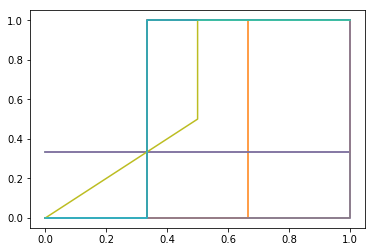

In [14]:
for i in range( 10 ):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(transformed, target, test_size=0.33)
    clf = svm.SVC(kernel='linear',probability=True)
    clf.fit( X_train, y_train ) 
    pred = clf.predict( X_test ) 
    prob = clf.predict_proba( X_test )
    fpr, tpr, __ = metrics.roc_curve( y_test, prob[:,0] ) 
    plt.plot( fpr, tpr ) 

1. First, see if there's a mvove th computer can make that will win the game (i.e. make the score 31). If there is, take that move. Otherwise, go to setp 2. 

2. See if there's a move the player could make that would cause the computer to lose the game (i.e. play a card such that computer cannot play). If there is, block that move. 

3. Play a predefined good/safe card. 

4. Play a different predefined safe card. 

5. Play the only legal card. 

6. Say "go" . 

In [35]:
def game():
    
    while True:
        
        deck = Deck()
        deck.shuffle()
        
        player_hand = deck.draw(4)
        ai_hand = deck.draw(4)
        
        game_on = True
        turn = np.random.choice([ 'player', '' ])
        
        count = 0
        plays = []
        
        def play( card ):
            nonlocal count 
            plays.append( card )
            count += card.value
        
        while game_on:
            if turn == 'player':
                # do player things 
                # like a player do 
                

                d = dict(enumerate(player_hand,1))
                inp = input( 'Choose one of {}'.format( d ) )
                play( d[ int(inp) ] )
                
                
            else:
                for c in ai_hand:
                    if count + c.value == 31:
                        play( c ) 
                for c in ai_hand:
                    play(c)

            print( 'Count is {}'.format( count ) ) 
    
        print( plays ) 
        break
    
    
game()

Choose one of {1: Ad, 2: 10h, 3: 9d, 4: 2h}1
Count is 1
Choose one of {1: Ad, 2: 10h, 3: 9d, 4: 2h}2
Count is 11
Choose one of {1: Ad, 2: 10h, 3: 9d, 4: 2h}3
Count is 20
Choose one of {1: Ad, 2: 10h, 3: 9d, 4: 2h}2
Count is 30
Choose one of {1: Ad, 2: 10h, 3: 9d, 4: 2h}1
Count is 31


KeyboardInterrupt: 